# Parallel External Source - Fork

In this tutorial we will show you how to run External Source operator in parallel mode using the `'fork'` method of starting Python workers.
This tutorial assumes, that you are already familiar with the previous [Parallel External Source](parallel_external_source.ipynb) tutorial that describes the requirements for the `source` parameter and how to configure both the pipeline and operator. It also explains how the External Source in parallel mode works under the hood.

## Steps To Start With Fork

Remember, that we do not want to acquire CUDA context before we worker threads in all DALI pipelines that we plan to use.

As mentioned in the previous tutorial, we need to follow those steps:

1. Define all DALI pipelines (do not use build())
2. Collect all DALI pipeline objects.
3. Run `start_py_workers()` on every pipeline object.

before we interact with CUDA (for example by using Deep Learning Framework that runs on GPU).

## Example Pipeline and `source`

Let's take the `source` callable defined in the previous tutorial. Compared to the `'spawn'` method, all the code from this process ends up copied into the forked process, thus we do not experience the problems with serialization. 

### Callable Object

In [1]:
import numpy as np
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn

batch_size = 6

class ExternalInputCallable:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line is not '']
            self.files, self.labels = zip(*file_label)
        self.n = len(self.files)

    def __call__(self, sample_info): 
        jpeg_filename = self.files[sample_info.idx_in_epoch]
        label = np.int32([self.labels[sample_info.idx_in_epoch]])
        with open(self.images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label

### Pipeline Definition

We want to check how to start several pipelines using `'fork'` method, thus we will define two pipelines - which usually happens with training and validation pipelines. First will use random adjustments, the second will not.

We define two pipelines, using `parallel=True` for External Source and 4 workers for each Pipeline. `'fork'` is the default starting method.

In [2]:
@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0, py_num_workers=4)
def training_pipeline():
    jpegs, labels = fn.external_source(source=ExternalInputCallable(batch_size),
                                       num_outputs=2, batch=False,
                                       parallel=True)
    decode = fn.decoders.image(jpegs, device="mixed")
    contrast = fn.random.uniform(range=(1, 3.0))
    enhance = fn.brightness_contrast(decode, contrast=contrast)
    return enhance, labels

@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0, py_num_workers=4)
def validation_pipeline():
    jpegs, labels = fn.external_source(source=ExternalInputCallable(batch_size),
                                       num_outputs=2, batch=False,
                                       parallel=True)
    decode = fn.decoders.image(jpegs, device="mixed") 
    enhance = fn.brightness_contrast(decode, contrast=1.5)
    return enhance, labels

### Displaying The Results

Let's introduce some helper code to display the results.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

def display(outputs, count, columns=2, captions=None, cpu=False):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i in range(count):
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(outputs.at(i) if cpu else outputs.as_cpu().at(i))



## Starting Python Workers

Now, that we defined the pipelines, we can continue with the step 2 and 3, that is collecting all pipeline objects and starting their workers.

In [4]:
train_pipe = training_pipeline()
val_pipe = validation_pipeline()

pipelines = [train_pipe, val_pipe]

for pipe in pipelines:
    pipe.start_py_workers()

### Running The Pipelines

Now that we started Python worker processes for all pipelines we can proceed with building and running them, which will acquire CUDA context in this Jupyter Notebook. You won't be able to start more worker processes with `'fork'` method without restarting the Kernel.

In [5]:
for pipe in pipelines:
    pipe.build()

In [6]:
train_out = train_pipe.run()
val_out = val_pipe.run()

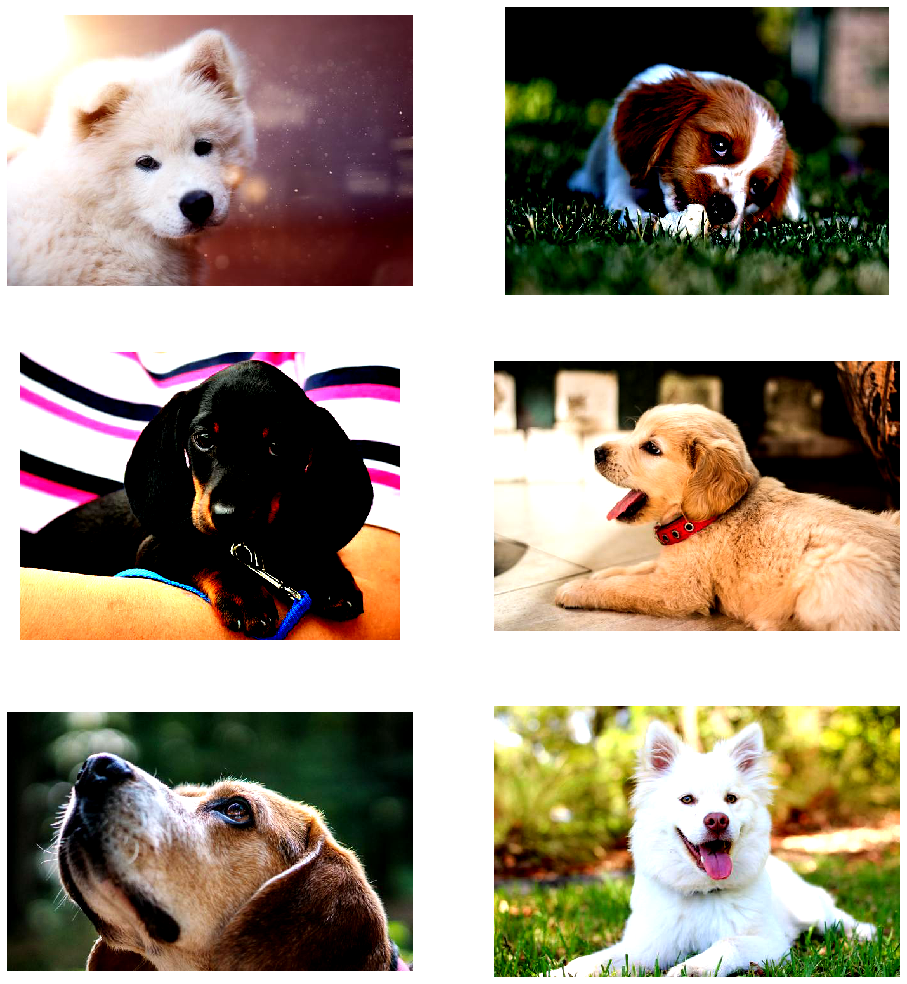

In [7]:
display(train_out[0], batch_size)

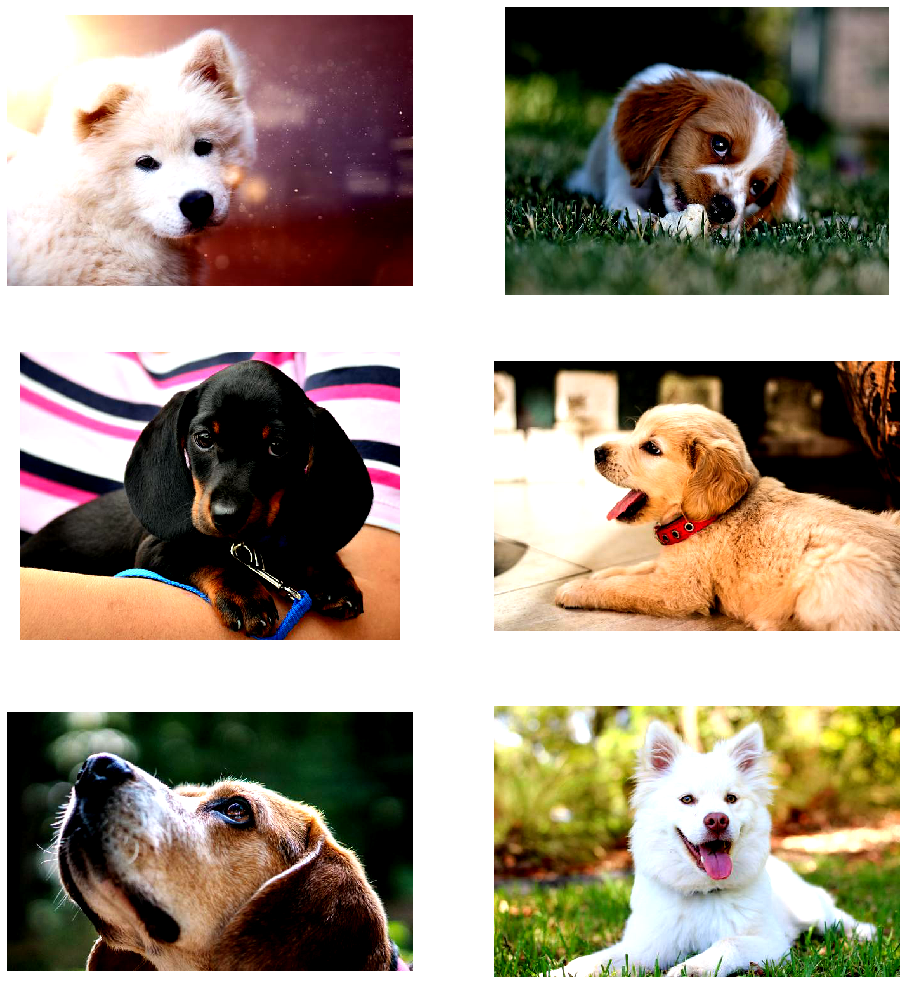

In [8]:
display(val_out[0], batch_size)